# Strategic users in EIP 1559

###### September 2020, [@barnabemonnot](https://twitter.com/barnabemonnot)
###### [Robust Incentives Group](https://github.com/ethereum/rig), Ethereum Foundation

---

In our [previous notebook](https://github.com/barnabemonnot/abm1559/blob/master/notebooks/stationary1559.ipynb), we simulated users interacting with the EIP 1559 transaction fee market mechanism for inclusion. Our users were strategic to some extent: they observed the prevailing basefee, evaluated their values and costs and decided whether to send a transaction or not. We saw that once the system reaches stationarity, users who aren't deterred by the basefee can expect next-block inclusion.

We made one big assumption there, which is that users respect the commonly stated heuristic of setting their premiums (in general, what the miner receives from the transaction) at a fixed value compensating the miner for the extra work of including one extra transaction. In this notebook, we relax this assumption and look at what happens when users bid strategically, trying to outcompete each other in transitionary periods, before the basefee settles.

Firstly, let's load up a few classes from our [`abm1559`](https://github.com/barnabemonnot/abm1559) library.

In [1]:
import os, sys
sys.path.insert(1, os.path.realpath(os.path.pardir))
# You may remove the two lines above if you have installed abm1559 from pypi

from abm1559.utils import constants

from abm1559.txpool import TxPool

from abm1559.users import User1559

from abm1559.userpool import UserPool

from abm1559.chain import (
    Chain,
    Block1559,
)

from abm1559.simulator import (
    spawn_poisson_heterogeneous_demand,
    update_basefee,
)

import pandas as pd
import numpy as np

## Introducing strategic users

Our previous simulation only featured one type of users, `User1559`. Users received some random value (in Gwei, per gas unit) for transaction inclusion and costs (in Gwei, per gas and time unit) for waiting.

For instance, Alice has 15 Gwei/gas value for inclusion, and cost 0.5 Gwei/gas/block. If Alice waits for 5 blocks to be included, her payoff for each gas unit she obtains is 15 - 5 * 0.5 = 12.5. To this, we subtract the fee Alice must pay for inclusion, or _gas price_. Assuming the basefee currently sits at 10 Gwei/gas and Alice set her premium at 1 Gwei/gas, her total gas price is 11 Gwei/gas. Her final payoff is then 12.5 - 11 = 1.5 Gwei/gas. In other words:

$$ \texttt{payoff} = \texttt{value} - \texttt{cost from waiting} - \texttt{transaction fee} $$

Users estimate their final payoff by estimating how long they will wait for inclusion. Our default `User1559` estimates a fixed waiting time of 5 blocks. Let's go ahead and change that to zero, as we have done with the `OptimisticUser` in the previous notebook. The `OptimisticUser` expects next block inclusion.

In [2]:
class OptimisticUser(User1559):
    def expected_time(self, params):
        return 0

`OptimisticUser`s expect a small waiting time, but still set their premium to a fixed value. Can a strategic user do better? Let's find out!

We'll subclass our `User1559` again to define the strategic user.

In [3]:
class StrategicUser(User1559):
    """
    A strategic affine user sending 1559 transactions.
    
    - Expects to be included in the next block
    - Prefers not to participate if its expected payoff is negative
    - Strategic gas_premium
    """
    
    epsilon = 0.1 # how much the user overbids by

    def expected_time(self, params):
        return 0

    def decide_parameters(self, params):
        if params["min_premium"] is None:
            min_premium = 1 * (10 ** 9)
        else:
            min_premium = params["min_premium"]

        gas_premium = min_premium + self.epsilon * (10 ** 9)
        max_fee = self.value

        return {
            "max_fee": max_fee, # in wei
            "gas_premium": gas_premium, # in wei
            "start_block": self.wakeup_block,
        }

    def export(self):
        return {
            **super().export(),
            "user_type": "strategic_user_1559",
        }

    def __str__(self):
        return f"1559 strategic affine user with value {self.value} and cost {self.cost_per_unit}"

As our `OptimisticUser` does, `StrategicUser` expects next-block inclusion. We also change `decide_parameters`: the strategic user sets its premium to _the minimum premium seen in the previous block_, plus 0.1 Gwei. Strategic users are trying to outbid the cheapest user (from the miner's point of view) who was included in the previous block.

Users attach premiums to their transactions as well as fee caps. The fee cap is an instruction to not charge a gas price greater than the cap, whatever happens with the basefee, and protects users from accidental overbidding. Miners receive either the whole premium or the slack between current basefee and feecap, whichever is lower. We call this the _tip_.

$$ \texttt{tip} = \min(\texttt{fee cap} - \texttt{basefee}, \texttt{gas premium}) $$

We set the fee cap of strategic users like we set it for non-strategic ones: since users receive at most their value from getting included, they set their cap to their value.

### Mixed simulations

We'll now put `OptimisticUser`s against `StrategicUser`s. We modify the `simulate` function we used previously to specify at each simulation step how much of each type we expect to spawn. These are the simulation steps:

1. We sample from a Poisson distribution to obtain the number of new users spawning between two blocks.
2. We spawn optimistic and strategic users according to the shares specified by `shares_scenario`.
3. Each user decides whether to transact or not (`decide_transactions`).
4. Transactions are added to the transaction pool.
5. The miner decides on a set of transactions to include, ranking transactions according to their tips, with higher tips at the top of the list.
6. A block is created and added to the chain.
7. Basefee is updated.
8. Repeat.

In [4]:
def simulate(demand_scenario, shares_scenario):
    # Instantiate a couple of things
    txpool = TxPool()
    basefee = constants["INITIAL_BASEFEE"]
    chain = Chain()
    metrics = []
    user_pool = UserPool()
    min_premium = 1 * (10 ** 9)

    for t in range(len(demand_scenario)):
        
        # `params` are the "environment" of the simulation
        params = {
            "basefee": basefee,
            "current_block": t,
            "min_premium": min_premium,
        }
        
        # We return some demand which on expectation yields demand_scenario[t] new users per round
        users = spawn_poisson_heterogeneous_demand(t, demand_scenario[t], shares_scenario[t])
        
        # Add users to the pool and check who wants to transact
        # We query each new user with the current basefee value
        # Users either return a transaction or None if they prefer to balk
        decided_txs = user_pool.decide_transactions(users, params)

        # New transactions are added to the transaction pool
        txpool.add_txs(decided_txs)

        # The best valid transactions are taken out of the pool for inclusion
        selected_txs = txpool.select_transactions(params)
        txpool.remove_txs([tx.tx_hash for tx in selected_txs])

        # We create a block with these transactions
        block = Block1559(txs = selected_txs, parent_hash = chain.current_head, height = t, basefee = basefee)

        # Record the min premium in the block
        min_premium = block.min_premium()
        
        # The block is added to the chain
        chain.add_block(block)
        
        # A couple of metrics we will use to monitor the simulation
        pool_strat_users = len(
                [tx for tx in txpool.txs.values() if type(user_pool.users[tx.sender]) == StrategicUser])
        pool_nonstrat_users = len(
                [tx for tx in txpool.txs.values() if type(user_pool.users[tx.sender]) == OptimisticUser])

        row_metrics = {
            "block": t,
            "basefee": basefee / (10 ** 9),
            "users": len(users),
            "strategic": len([user for user in users if type(user) == StrategicUser]),
            "nonstategic": len([user for user in users if type(user) == OptimisticUser]),
            "decided_txs": len(decided_txs),
            "included_txs": len(selected_txs),
            "blk_min_premium": block.min_premium() / (10 ** 9), # to Gwei
            "blk_avg_gas_price": block.average_gas_price(),
            "blk_avg_tip": block.average_tip(),
            "pool_length": txpool.pool_length,
            "pool_strat_users": pool_strat_users,
            "pool_nonstrat_users": pool_nonstrat_users,
        }
        metrics.append(row_metrics)

        # Finally, basefee is updated and a new round starts
        basefee = update_basefee(block, basefee)

    return (pd.DataFrame(metrics), user_pool, chain)

We'll start with a simulation for 200 blocks. We set equal shares of strategic and non-strategic users, with on average a total of 2500 users spawning each round. Remember that our blocks can accommodate at most 952 users, but target inclusion of about half of this number, i.e., 475 of them. There is plenty of space then for strategic users (on average 1250 of them each round) to grab all the available space.

In [5]:
blocks = 100
demand_scenario = [2500 for i in range(blocks)]

strategic_share = 0.5
shares_scenario = [{
    StrategicUser: strategic_share,
    OptimisticUser: 1 - strategic_share,
} for i in range(blocks)]

(df, user_pool, chain) = simulate(demand_scenario, shares_scenario)

What does `df` reveal?

In [6]:
df

,block,basefee,users,strategic,nonstategic,decided_txs,included_txs,blk_min_premium,blk_avg_gas_price,blk_avg_tip,pool_length,pool_strat_users,pool_nonstrat_users
0,0,1.000000,2492,1246,1246,2217,952,1.1,2.100000,1.100000,1265,153,1112
1,1,1.124900,2529,1264,1265,2253,952,1.2,2.324900,1.200000,2566,327,2239
2,2,1.265400,2455,1227,1228,2182,952,1.3,2.565400,1.300000,3796,446,3350
3,3,1.423448,2524,1262,1262,2211,952,1.4,2.823448,1.400000,5055,606,4449
4,4,1.601237,2535,1267,1268,2171,952,1.5,3.101237,1.500000,6274,729,5545
...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,95,15.221769,2446,1223,1223,461,461,1.0,16.269925,1.048156,12484,206,12278
96,96,15.161072,2573,1286,1287,476,476,1.0,16.210862,1.049790,12484,206,12278
97,97,15.160314,2552,1276,1276,477,477,1.0,16.210419,1.050105,12484,206,12278
98,98,15.163535,2464,1232,1232,489,489,1.0,16.216092,1.052556,12484,206,12278


We see on average 2500 `users`, with half of them `strategic` and the other half `nonstrategic`. Many decide to transact in the first few rounds, more than are eventually included (`decided_txs` > `included_txs`). The pool length, i.e., how many decided transactions were not included yet, increases steadily, with most users in the pool non-strategic users! We have the first clue that being strategic is not a bad idea, so let's dig a little more in results.

### Strategic users enter a bidding war

Let's look at the basefee and the minimum premium in a block.

<AxesSubplot:xlabel='block'>

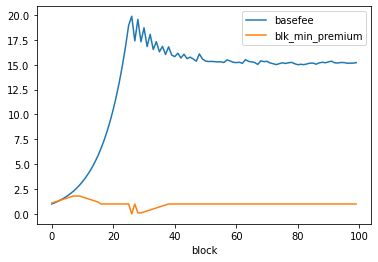

In [7]:
df.plot("block", ["basefee", "blk_min_premium"])

In [8]:
df[(df.block >= 24) & (df.block <= 27)]

,block,basefee,users,strategic,nonstategic,decided_txs,included_txs,blk_min_premium,blk_avg_gas_price,blk_avg_tip,pool_length,pool_strat_users,pool_nonstrat_users
24,24,16.855204,2437,1218,1219,252,952,1.0,17.867809,1.012605,16756,206,16550
25,25,18.960418,2527,1263,1264,1,661,1.0,19.478373,0.517954,16096,206,15890
26,26,19.880236,2547,1273,1274,0,0,0.0,0.000000,0.000000,16096,206,15890
27,27,17.395206,2540,1270,1270,246,952,1.0,18.208404,0.813197,15390,350,15040


Basefee increases until reaching its apex at block 26. This is the same behaviour we observed in the previous notebook: too many users want in so the basefee quickly reaches a high value, where no one is willing to pay this much. After the apex, the basefee climbs down, accommodating some of the most high-valued new users as well as equally high-valued users in the pool who were priced out.

We also plot (as seen in orange in the previous graph) the minimum premium observed in the block. The dynamics are curious: to understand them, remember that strategic users systematically bid just above the minimum premium observed in the previous block. During the transitionary period between blocks 0 and 26, too many users want in so the basefee increases. At the same time, the minimum premium observed in a block increases too. We can imagine that enough strategic users successfully outbid non-strategic ones to fill the whole block. Since strategic users always bid above the smallest premium in the previous block, they bid a premium of 1.1 Gwei the first time, then 1.2, then 1.3 etc. At this point, we recognise the unstable dynamics of the current first-price auction paradigm, where users bid _against each other_ instead of bidding their true value.

As the basefee increases, fewer and fewer new strategic users decide to transact, since **low-valued users are priced out**, leaving some space for non-strategic users to be included. This releases some pressure on the premiums, until block 26 where the basefee is so high that no one is included (and the minimum premium is zero).

<AxesSubplot:xlabel='block'>

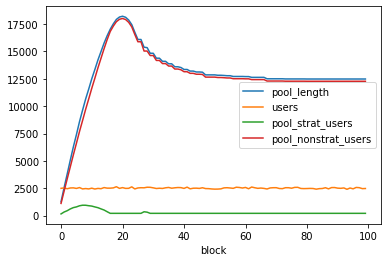

In [9]:
df.plot("block", ["pool_length", "users", "pool_strat_users", "pool_nonstrat_users"])

We observe in the chart above the transaction pool length, and indeed confirm that most users in the pool are non-strategic. **Strategic users get ahead by outbidding them**.

### When basefee settles, strategic behaviour does not help

We'll now look at the trace more closely. We export simulation data to pandas `DataFrame`s for ease of manipulation, using the `export` methods we defined in our classes.

In [10]:
# Obtain the pool of users (all users spawned by the simulation)
user_pool_df = user_pool.export().rename(columns={ "pub_key": "sender" })

# Export the trace of the chain, all transactions included in blocks
chain_df = chain.export()

# Join the two to associate transactions with their senders
user_txs_df = chain_df.join(user_pool_df.set_index("sender"), on="sender")

For now we'll only look at the distribution of strategic vs. non-strategic users in the blocks.

In [11]:
# Obtain per user type statistics
txs_per_user_type = user_txs_df.groupby(
    ["block_height", "user_type"]
).agg(
    { "user_type": len }
).unstack(level=-1).reset_index()

txs_per_user_type["user_type"] = txs_per_user_type["user_type"].fillna(0)

txs_per_user_type.columns = ["block_height", "strategic", "nonstrategic"]

txs_per_user_type["total"] = txs_per_user_type.apply(
    lambda row: row.strategic + row.nonstrategic,
    axis = 1
)
txs_per_user_type["percent_strategic"] = txs_per_user_type.apply(
    lambda row: row.strategic / row.total * 100,
    axis = 1
)

We first check how many users in each block are strategic/non-strategic.

<AxesSubplot:xlabel='block_height'>

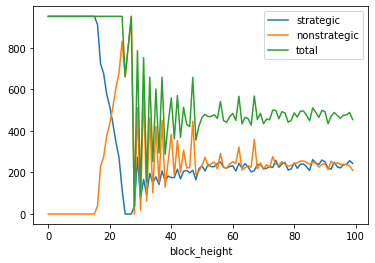

In [12]:
txs_per_user_type.plot("block_height", ["strategic", "nonstrategic", "total"])

From this plot, a few observations stand out:
    
1. For the first few blocks, only strategic users are included.
2. This changes before the basefee reaches its apex (at block 26), as more and more non-strategic users are included. By block 20, more non-strategic users are included than strategic.
3. There are weird sawtooths between blocks 25 and 50. I don't believe these have much interpretation, having more to do with discontinuous behaviour of the simulation. When the basefee drops by a small amount, some users in the pool are included, sometimes enough for the basefee to increase again, after which most users cannot get in. This keeps on going until all users left in the pool have a fee cap lower than the stationary basefee level.
4. Once series stabilise, we observe that strategic and non-strategic users get in at equal ratio. Remember that we spawn equal numbers of strategic and non-strategic users each round, so we may conclude here that strategic users lost their overbidding advantage: at this point, the basefee is more determinant to decide who gets in or not.

This is confirmed by the following plot, which shows the percentage of strategic users in each block.

<AxesSubplot:xlabel='block_height'>

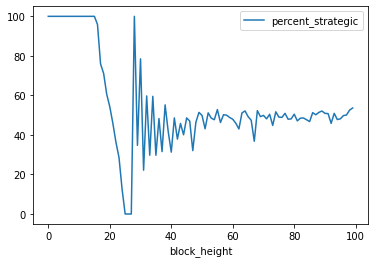

In [13]:
txs_per_user_type.plot("block_height", "percent_strategic")

### Piecing parts together

In the chart above, between blocks 0 and 26, before basefee reaches its apex, strategic users are included in much higher proportions than non-strategic users. Not surprising, since they post higher premiums. More surprising however is that this proportion is decreasing, until it is reversed: by block 20, more non-strategic users are included than strategic.

This is trickier to explain but we can sketch the following narrative.

1. Most users, both strategic and non-strategic, have valid transactions (for which the cap is above the basefee) to send. Strategic users get in first and take all the slots.
2. Users start being discriminated by the basefee. Strategic users with valid transactions get in, some non-strategic users get in too.
3. Basefee keeps increasing. _High-valued_ non-strategic users which were languishing in the pool start filling the block, while most new, _low-valued_ strategic users are priced out.
4. Basefee hits highest level. No one gets in.
5. Basefee starts decreasing. Valid leftovers in the pool (almost all of them non-strategic) are included with some of the new users.
6. Basefee stabilises. Only new users are included, no one in the pool is valid anymore.

It is expected to find this instability during transitionary periods, where the basefee needs to adapt to a changing demand, e.g., a spike in transactions or higher values for transacting. We find however that once the basefee settles, strategic users no longer have the edge over nonstrategic ones: the basefee is the true determinant for inclusion.

## Value bidding

In this section, we change the bidding behaviour once more. Previously, we looked at `OptimisticUser`s who set their gas premium to 1 Gwei, a small, fixed value meant to compensate miner work, or `StrategicUser`s who overbid when blocks are full. With EIP 1559 implemented, it is reasonable to believe most users would follow this simple bidding strategy: look at the gasprice level (the current basefee plus this 1 Gwei premium) and decide sending their transaction or not, sometimes adjusting the premium when congestion spikes.

We'll relax this assumption however, and look at the case where users **set their premium according to their value for the transaction**: the higher their value, the greater the premium.

In [14]:
class OptimisticUser(User1559):
    def expected_time(self, params):
        return 0
    
    def decide_parameters(self, params):
        # Users add a fraction of their value to their premium
        # Higher value users thus have higher premiums, all else equal
        gas_premium = 1 * (10 ** 9) + self.value // 1000
        max_fee = self.value
        
        return {
            "max_fee": max_fee,
            "gas_premium": gas_premium, # in wei
            "start_block": self.wakeup_block,
        }
    
class StrategicUser(User1559):
    """
    A strategic affine user sending 1559 transactions.
    
    - Expects to be included in the next block
    - Prefers not to participate if its expected payoff is negative
    - Strategic gas_premium
    """
    
    epsilon = 0.1 # how much the user overbids by

    def expected_time(self, params):
        return 0

    def decide_parameters(self, params):
        if params["min_premium"] is None:
            min_premium = 1 * (10 ** 9)
        else:
            min_premium = params["min_premium"]

        gas_premium = min_premium  + self.value // 1000 + self.epsilon * (10 ** 9)
        max_fee = self.value

        return {
            "max_fee": max_fee, # in wei
            "gas_premium": gas_premium, # in wei
            "start_block": self.wakeup_block,
        }

    def export(self):
        return {
            **super().export(),
            "user_type": "strategic_user_1559",
        }

    def __str__(self):
        return f"1559 strategic affine user with value {self.value} and cost {self.cost_per_unit}"

Run the simulation again.

In [15]:
strategic_share = 0.5
shares_scenario = [{
    StrategicUser: strategic_share,
    OptimisticUser: 1 - strategic_share,
} for i in range(blocks)]

(df, user_pool, chain) = simulate(demand_scenario, shares_scenario)

Basefee and minimum premiums have similar dynamics.

<AxesSubplot:xlabel='block'>

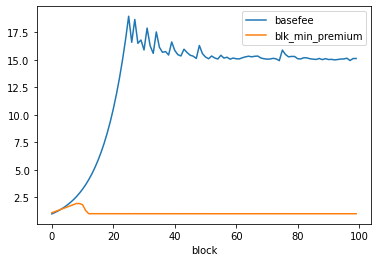

In [16]:
df.plot("block", ["basefee", "blk_min_premium"])

We obtain the average value of included strategic and non-strategic users.

<AxesSubplot:xlabel='block_height'>

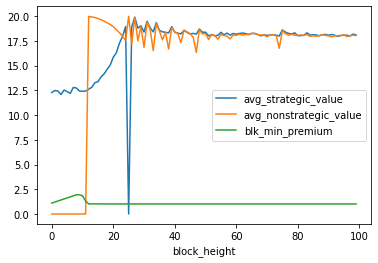

In [17]:
# Obtain the pool of users (all users spawned by the simulation)
user_pool_df = user_pool.export().rename(columns={ "pub_key": "sender" })

# Export the trace of the chain, all transactions included in blocks
chain_df = chain.export()

# Join the two to associate transactions with their senders
user_txs_df = chain_df.join(user_pool_df.set_index("sender"), on="sender")

# Obtain per user type statistics
txs_per_user_type = user_txs_df.groupby(
    ["block_height", "user_type"]
).agg(
    { "value": np.mean }
).unstack(level=-1).reset_index()

txs_per_user_type["value"] = txs_per_user_type["value"].fillna(0)

txs_per_user_type.columns = ["block_height", "avg_strategic_value", "avg_nonstrategic_value"]
txs_per_user_type["blk_min_premium"] = df["blk_min_premium"]

txs_per_user_type.plot("block_height", ["avg_strategic_value", "avg_nonstrategic_value", "blk_min_premium"])

We recognise familiar dynamics: for the first 10 blocks or so, non-strategic users are not included, being outbid by strategic users. Once the basefee prices out enough transactions, there is room for strategic users to join. High-value users get in first, since their premium increases with their value. Yet once the basefee stabilises, both groups of included users have equal average value.

It is useful to obtain a counterfactual, to check what the results would be with all users non-strategic. We set the `strategic_share` to zero and run the simulation again.

In [18]:
strategic_share = 0
shares_scenario = [{
    StrategicUser: strategic_share,
    OptimisticUser: 1 - strategic_share,
} for i in range(blocks)]

(df2, user_pool2, chain2) = simulate(demand_scenario, shares_scenario)

In [19]:
# Obtain the pool of users (all users spawned by the simulation)
user_pool_df2 = user_pool2.export().rename(columns={ "pub_key": "sender" })

# Export the trace of the chain, all transactions included in blocks
chain_df2 = chain2.export()

# Join the two to associate transactions with their senders
user_txs_df2 = chain_df2.join(user_pool_df2.set_index("sender"), on="sender")

# Obtain per user type statistics
txs_per_user_type2 = user_txs_df2.groupby(
    ["block_height", "user_type"]
).agg(
    { "value": ["mean"] }
).unstack(level=-1).fillna(0).reset_index()

We look at the average value of included users in our original scenario and the counterfactual.

(10.0, 21.0)

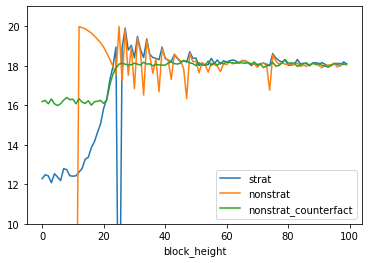

In [20]:
compare = pd.DataFrame({
    "block_height": txs_per_user_type.iloc[:,0],
    "strat": txs_per_user_type.iloc[:,1],
    "nonstrat": txs_per_user_type.iloc[:,2],
    "nonstrat_counterfact": txs_per_user_type2.iloc[:,1] })

compare.plot("block_height", ["strat", "nonstrat", "nonstrat_counterfact"]).set_ylim([10, 21])

In the counterfactual scenario, where all users are non-strategic, the average value of included users in the first few blocks is around 16 Gwei per gas. Meanwhile, the average value of included users in the original scenario starts from 12 Gwei per gas!

We see here the impact of various bidding behaviours on **efficiency**. Auctions are typically deemed efficient when high-value users get what what they want, e.g., when the item being auctioned goes to who wants it the most. When users bid as they do in a first-price auction, the fee market is less efficient than when users are non-strategic. Fortunately, **this inefficiency doesn't last**: once the basefee reaches its stationary level, in both the original scenario as well as the counterfactual, similar-valued users are included (namely, the top 475 of them).

In future notebooks, we'll investigate the efficiency properties of different fee market mechanisms.

---

_Acknowledgements_: Fred Lacs for comments and code.